### Preliminary cell to start the notebook

In [1]:
# libraries
import os
import sys
import platform
print(sys.version)

in_colab = 'google.colab' in sys.modules
strong_pc = platform.system() == 'Linux'

if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
#df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')
samplerate = 44100

3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open fil

TensorFlow version: 2.12.0
keras version = 2.12.0


In [2]:
strong_pc

False

# 3 UNSUPERVISED LEARNING: AUTOENCODERS

In [3]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

## 3.4 Autoencoder on preprocessed audio STFT on augmented ESC-50 - Convolutional and flatten code

Here we try to train the AE on ESC-50 Augmented instead. We are gonna use ESC-50 to run the grid search of the AE and then we will use ESC-50 Augmented to train the best one. Actually we are goint to use only a small subset of ESC-50 for the gridsearch.

### Create the dataset

In [16]:
seed = 42
tf.random.set_seed(seed)
ESC50_path = os.path.join(main_dir,'data', 'ESC-50-depth')
batch_size = 30
preprocessing = 'STFT'
AE_name = 'AE_Conv_prep_flatten_'+preprocessing+'_Augmented'

#we are gonna use ESC-50 to run the grid search of the AE and then we will use ESC-50 Augmented to train the best one
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(ESC50_path,
                                                verbose = 0,
                                                batch_size = batch_size,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT", "MEL", "MFCC" or None
                                                show_example_batch = True,
                                                resize = True,
                                                ndim=3)

Found 2000 files belonging to 50 classes.
Using 1500 files for training.
Using 500 files for validation.


2023-09-11 00:59:42.233446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1500]
	 [[{{node Placeholder/_4}}]]
2023-09-11 00:59:42.233622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1500]
	 [[{{node Placeholder/_4}}]]
2023-09-11 00:59:49.444343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype float
	 [[{{node Placeh

In [17]:
# every batch has the shape (batch_size, 128, 64, 1), swap 128 and 64
# in order to have the shape (batch_size, 64, 128, 1)
train = train.map(lambda x, y: (tf.transpose(x, perm=[0, 2, 1, 3]), y))
val = val.map(lambda x, y: (tf.transpose(x, perm=[0, 2, 1, 3]), y))
test = test.map(lambda x, y: (tf.transpose(x, perm=[0, 2, 1, 3]), y))

INPUT_DIM = (64,128,1)

In [18]:
# map the first element of the train dataset over the second and overwrite it
# we do it in order to have the same input and output for the autoencoder
train = train.map(lambda x, y: (x, x))
val = val.map(lambda x, y: (x, x))
test = test.map(lambda x, y: (x, x))

In [19]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ AE_name+'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created AE_Conv_prep_flatten_STFT_Augmented_count.txt with content '0' in folder Saved_Models


### Preparation to use Keras-Tuner

Now we define a function to build a generic convolutional autoencoder. We'll give this function to a keras tuner.

In [8]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 32
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = 'valid',
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [9]:
verbose = 0
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 3)
if verbose > 1:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)

Model built with 226403 trainable params


In [10]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp,test=False):

    #define hyperparameters
    if test: #if test is true you run the tuner only on a reduced hyperparameter space
        print('Running a test smaller grid search')
        n_units = 32
        n_layers = hp.Choice(name = 'n_layers', values =  [2,3])
        kernel_size = 3
        strides = 2
        max_pooling = 2
        regularizer = hp.Choice(name = 'regularizer', values = [1e-4,0.0])
        padding = 'same'
        code_size = 32
        activation = 'tanh'
        drop_out = hp.Choice(name = 'drop_out', values = [0.25,0.0])
        batch_norm = True
        lr_max, lr_min = 1e-3, 1e-3
        hp_lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    else:
        n_units = hp.Choice(name = 'n_units', values =  [4,8,16,32,64,128], default = 32)
        n_layers = hp.Int(name = 'n_layers', min_value = 1, max_value = 3, step=1, sampling='linear', default = 2)
        kernel_size = hp.Choice(name = 'kernel_size', values = [3,5,7], default = 3)
        strides = hp.Choice(name = 'strides', values = [2,3], default = 2)
        max_pooling = hp.Choice(name = 'max_pooling' , values = [2,3], default = 2)
        regularizer = hp.Choice(name = 'regularizer', values = [0.0,1e-2,1e-3,1e-4,1e-5], default = 1e-4)
        padding = hp.Choice(name = 'padding', values = ['same','valid'], default = 'valid')
        code_size = hp.Choice(name = 'code_size', values = [32,64,128], default = 32)
        activation = hp.Choice(name = 'activation', values = ['relu','elu','tanh'], default = 'tanh')
        drop_out = hp.Choice(name = 'drop_out', values = [0.0, 0.25, 0.5], default = 0.0)
        batch_norm = hp.Choice(name = 'batch_norm', values = [True, False], default = True)
        lr_min, lr_max =1e-4, 1e-1
        learning_rate= hp.Choice('learning_rate', values = [1e-4, 1e-3, 5*1e-3, 1e-2,5*1e-2,1e-1], default = 1e-3)


    model = build_autoencoder(code_size = code_size,
                              activation = activation,
                              padding = padding,
                              n_layers = n_layers,
                              n_units = n_units,
                              kernel_size = (kernel_size,kernel_size),
                              strides = (strides,strides),
                              max_pooling = (max_pooling, max_pooling),
                              regularizer = regularizer,
                              batch_norm = batch_norm,
                              drop_out = drop_out,
                              learning_rate= learning_rate)

    return model

In [11]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 189795 trainable params
Model: "AE_Conv_prep_flatten_STFT_Augmented"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                84768     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        105349    
                                                                 
Total params: 190,117
Trainable params: 189,795
Non-trainable params: 322
_________________________________________________________________


### Implement the grid search hyperparamter-wise

In [66]:
# dictionary with the default values of the hyperparams to be update each time
default_values = {
    'n_layers': 2,
    'n_units': 32,
    'kernel_size': 3,
    'strides':2,
    'max_pooling':2,
    'regularizer':0.0,
    'padding':'valid',
    'code_size':32,
    'activation':'tanh',
    'drop_out':0.0,
    'batch_norm':True,
    'learning_rate':1e-3
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
problematic_combination = []
max_model_size = 10**6
max_trials = 10
dir_name = AE_name
verbose=0

if strong_pc:
    train_small = train
    val_small = val
else:
    small_size_dataset = 400
    train_val_small = train.unbatch().take(small_size_dataset)
    train_small = train_val_small.skip(40).batch(20)
    val_small = train_val_small.take(40).batch(20)

# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
}

#to be consistent with this type of grd search we should pass each hp more than one time...
for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                hp.Fixed(name = fixed_param, value = default_values[fixed_param])

        if verbose>1:
            display(hp.space)

        try:
            #create a tuner for the params not fixed
            tuner = build_tuner(build_model = build_model,
                                hpo_method = hpo_method,
                                max_model_size = max_model_size,
                                max_trials = max_trials,
                                dir_name = dir_name,
                                overwrite = True,
                                objective = kt.Objective('val_mse', direction='min'),
                                hp=hp,
                                not_fixed_param = hyper_params,
                                tune_new_entries=True
                                )

            if verbose>2:
                display(tuner.search_space_summary(extended = True))

            #fit the tuner
            epochs = 50
            patience = 10
            metrics = ['mse']
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                        verbose=verbose,
                                                        patience=patience)]

            tuner.search(train_small, validation_data = val_small,
                                callbacks=callbacks,
                                epochs=epochs,
                                verbose=int(verbose>0),
                        )

            #retrive the best value for the free hp
            best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

            #retrive the best score reached
            best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']

            print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
            best_score_dict[hpo_method].append(best_score)

            #update the default dict of values
            default_values[hyper_params] = best_value

            #save the updated dictionary
            file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
            with open(file_path, 'wb') as file:
                pickle.dump(default_values, file)

            #delete the folder just created by the run
            shutil.rmtree(os.path.join(main_dir,dir_name, hpo_method+'_'+hyper_params))

        except:
            problematic_combination.append(('search_for'+hyper_params, default_values))

    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)

#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores'+preprocessing)
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)

display(problematic_combination)

Searching for the best value for n_units
Using Random Search strategy for HPO
Model built with 189795 trainable params
Model built with 189795 trainable params


2023-09-10 23:51:51.047061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1500]
	 [[{{node Placeholder/_0}}]]
2023-09-10 23:51:51.047426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1500]
	 [[{{node Placeholder/_0}}]]
2023-09-10 23:51:51.839486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1500]

Model built with 81091 trainable params
Model built with 490147 trainable params
Model built with 17707 trainable params
Model built with 1422627 trainable params


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/

Model built with 37107 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 189795 trainable params


2023-09-10 23:52:50.649742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float
	 [[{{node Placeholder/_20}}]]
2023-09-10 23:52:50.650002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [500]
	 [[{{node Placeholder/_4}}]]


9/9 [==============================] - 1s 133ms/step - loss: 0.0519 - mse: 0.0519
The best value for n_units is 32, the best score is 0.05185145139694214
Searching for the best value for code_size
Using Random Search strategy for HPO
Model built with 189795 trainable params


Model built with 320899 trainable params
Model built with 583107 trainable params
Model built with 189795 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 189795 trainable params
9/9 [==============================] - 0s 8ms/step - loss: 0.3682 - mse: 0.3682
The best value for code_size is 32, the best score is 0.3681783974170685
Searching for the best value for kernel_size
Using Random Search strategy for HPO
Model built with 189795 trainable params


Model built with 243875 trainable params
Model built with 393635 trainable params
Model built with 189795 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 243875 trainable params
9/9 [==============================] - 0s 10ms/step - loss: 0.0298 - mse: 0.0298
The best value for kernel_size is 5, the best score is 0.029840286821126938
Searching for the best value for activation
Using Random Search strategy for HPO
Model built with 243875 trainable params


Model built with 243875 trainable params
Model built with 243875 trainable params
Model built with 243875 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 243875 trainable params
9/9 [==============================] - 0s 10ms/step - loss: 0.0120 - mse: 0.0120
The best value for activation is elu, the best score is 0.012003432959318161
Searching for the best value for strides
Using Random Search strategy for HPO
Model built with 243875 trainable params


Model built with 168995 trainable params
Model built with 243875 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 243875 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0103 - mse: 0.0103
The best value for strides is 2, the best score is 0.01025526411831379
Searching for the best value for batch_norm
Using Random Search strategy for HPO
Model built with 243875 trainable params


Model built with 243553 trainable params
Model built with 243875 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 243553 trainable params
9/9 [==============================] - 0s 8ms/step - loss: 0.0104 - mse: 0.0104
The best value for batch_norm is 0, the best score is 0.010385621339082718
Searching for the best value for n_layers
Using Random Search strategy for HPO
Model built with 243553 trainable params


Model built with 243553 trainable params


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/

Model built with 968865 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 243553 trainable params
9/9 [==============================] - 0s 8ms/step - loss: 0.0098 - mse: 0.0098
The best value for n_layers is 2, the best score is 0.009768742136657238
Searching for the best value for drop_out
Using Random Search strategy for HPO
Model built with 243553 trainable params


Model built with 243553 trainable params
Model built with 243553 trainable params
Model built with 243553 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 243553 trainable params
9/9 [==============================] - 0s 8ms/step - loss: 0.0108 - mse: 0.0108
The best value for drop_out is 0.25, the best score is 0.010841700248420238
Searching for the best value for regularizer
Using Random Search strategy for HPO
Model built with 243553 trainable params


Model built with 243553 trainable params
Model built with 243553 trainable params
Model built with 243553 trainable params
Model built with 243553 trainable params
Model built with 243553 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 243553 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0129 - mse: 0.0103
The best value for regularizer is 0.0001, the best score is 0.010324292816221714
Searching for the best value for padding
Using Random Search strategy for HPO
Model built with 243553 trainable params


Model built with 243553 trainable params
Model built with 289313 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 289313 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0099 - mse: 0.0090
The best value for padding is same, the best score is 0.009011225774884224
Searching for the best value for learning_rate
Using Random Search strategy for HPO
Model built with 289313 trainable params


Model built with 289313 trainable params
Model built with 289313 trainable params
Model built with 289313 trainable params
Model built with 289313 trainable params
Model built with 289313 trainable params
Model built with 289313 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 289313 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0155 - mse: 0.0121
The best value for learning_rate is 0.001, the best score is 0.012147362343966961
Searching for the best value for max_pooling
Using Random Search strategy for HPO
Model built with 289313 trainable params


Model built with 189473 trainable params
Model built with 289313 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 289313 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0130 - mse: 0.0104
The best value for max_pooling is 2, the best score is 0.010407300665974617


{'n_layers': 2,
 'n_units': 32,
 'kernel_size': 5,
 'strides': 2,
 'max_pooling': 2,
 'regularizer': 0.0001,
 'padding': 'same',
 'code_size': 32,
 'activation': 'elu',
 'drop_out': 0.25,
 'batch_norm': 0,
 'learning_rate': 0.001}

Searching for the best value for kernel_size
Using Bayesian Optimization strategy for HPO
Model built with 189473 trainable params


Model built with 289313 trainable params
Model built with 439073 trainable params
Model built with 189473 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 289313 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0108 - mse: 0.0098
The best value for kernel_size is 5, the best score is 0.00984370056539774
Searching for the best value for code_size
Using Bayesian Optimization strategy for HPO
Model built with 289313 trainable params


Model built with 420417 trainable params
Model built with 682625 trainable params
Model built with 289313 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 10ms/step - loss: 0.0107 - mse: 0.0097
The best value for code_size is 64, the best score is 0.009711629711091518
Searching for the best value for n_units
Using Bayesian Optimization strategy for HPO
Model built with 420417 trainable params


Model built with 420417 trainable params
Model built with 171841 trainable params
Model built with 1147969 trainable params
Model built with 35809 trainable params


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/

Model built with 3524673 trainable params
Model built with 76353 trainable params


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0098 - mse: 0.0092
The best value for n_units is 32, the best score is 0.009166402742266655
Searching for the best value for learning_rate
Using Bayesian Optimization strategy for HPO
Model built with 420417 trainable params


Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0164 - mse: 0.0120
The best value for learning_rate is 0.001, the best score is 0.011982386000454426
Searching for the best value for drop_out
Using Bayesian Optimization strategy for HPO
Model built with 420417 trainable params


Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 10ms/step - loss: 0.0094 - mse: 0.0088
The best value for drop_out is 0.25, the best score is 0.008788468316197395
Searching for the best value for n_layers
Using Bayesian Optimization strategy for HPO
Model built with 420417 trainable params


Model built with 420417 trainable params
Model built with 616385 trainable params
Model built with 2115233 trainable params
INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/

Model built with 420417 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0096 - mse: 0.0088
The best value for n_layers is 2, the best score is 0.008791901171207428
Searching for the best value for regularizer
Using Bayesian Optimization strategy for HPO
Model built with 420417 trainable params


Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0113 - mse: 0.0097
The best value for regularizer is 0.001, the best score is 0.009733167476952076
Searching for the best value for padding
Using Bayesian Optimization strategy for HPO
Model built with 329601 trainable params


Model built with 329601 trainable params
Model built with 420417 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 12ms/step - loss: 0.0114 - mse: 0.0099
The best value for padding is same, the best score is 0.009945179335772991
Searching for the best value for strides
Using Bayesian Optimization strategy for HPO
Model built with 420417 trainable params


Model built with 222273 trainable params
Model built with 420417 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0110 - mse: 0.0095
The best value for strides is 2, the best score is 0.00949953868985176
Searching for the best value for activation
Using Bayesian Optimization strategy for HPO
Model built with 420417 trainable params


Model built with 420417 trainable params
Model built with 420417 trainable params
Model built with 420417 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0109 - mse: 0.0094
The best value for activation is elu, the best score is 0.009417708031833172
Searching for the best value for batch_norm
Using Bayesian Optimization strategy for HPO
Model built with 420739 trainable params


Model built with 420417 trainable params
Model built with 420739 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 420417 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0128 - mse: 0.0111
The best value for batch_norm is 0, the best score is 0.01106528751552105
Searching for the best value for max_pooling
Using Bayesian Optimization strategy for HPO
Model built with 420417 trainable params


Model built with 222273 trainable params
Model built with 420417 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 222273 trainable params
9/9 [==============================] - 0s 10ms/step - loss: 0.0118 - mse: 0.0105
The best value for max_pooling is 3, the best score is 0.010452006943523884


{'n_layers': 2,
 'n_units': 32,
 'kernel_size': 5,
 'strides': 2,
 'max_pooling': 3,
 'regularizer': 0.001,
 'padding': 'same',
 'code_size': 64,
 'activation': 'elu',
 'drop_out': 0.25,
 'batch_norm': 0,
 'learning_rate': 0.001}

Searching for the best value for n_units
Using Hyperband strategy for HPO
Model built with 222273 trainable params


Model built with 222273 trainable params
Model built with 72769 trainable params
Model built with 751681 trainable params
Model built with 11041 trainable params
Model built with 2732097 trainable params


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^

Model built with 26817 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 222273 trainable params
9/9 [==============================] - 0s 8ms/step - loss: 0.0445 - mse: 0.0325
The best value for n_units is 32, the best score is 0.03248069807887077
Searching for the best value for padding
Using Hyperband strategy for HPO
Model built with 180993 trainable params


Model built with 180993 trainable params
Model built with 222273 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 222273 trainable params
9/9 [==============================] - 0s 19ms/step - loss: 0.0398 - mse: 0.0281
The best value for padding is same, the best score is 0.028106605634093285
Searching for the best value for drop_out
Using Hyperband strategy for HPO
Model built with 222273 trainable params


Model built with 222273 trainable params
Model built with 222273 trainable params
Model built with 222273 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 222273 trainable params
9/9 [==============================] - 0s 8ms/step - loss: 0.0370 - mse: 0.0246
The best value for drop_out is 0.0, the best score is 0.024550937116146088
Searching for the best value for regularizer
Using Hyperband strategy for HPO
Model built with 222273 trainable params


Model built with 222273 trainable params
Model built with 222273 trainable params
Model built with 222273 trainable params
Model built with 222273 trainable params
Model built with 222273 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 222273 trainable params
9/9 [==============================] - 0s 7ms/step - loss: 0.0417 - mse: 0.0270
The best value for regularizer is 0.001, the best score is 0.026956863701343536
Searching for the best value for activation
Using Hyperband strategy for HPO
Model built with 222273 trainable params


Model built with 222273 trainable params
Model built with 222273 trainable params
Model built with 222273 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 222273 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0412 - mse: 0.0261
The best value for activation is elu, the best score is 0.026092736050486565
Searching for the best value for code_size
Using Hyperband strategy for HPO
Model built with 189473 trainable params


Model built with 222273 trainable params
Model built with 287873 trainable params
Model built with 189473 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 287873 trainable params
9/9 [==============================] - 0s 16ms/step - loss: 0.0380 - mse: 0.0252
The best value for code_size is 128, the best score is 0.025183187797665596
Searching for the best value for max_pooling
Using Hyperband strategy for HPO
Model built with 682625 trainable params


Model built with 287873 trainable params
Model built with 682625 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 682625 trainable params
9/9 [==============================] - 0s 11ms/step - loss: 0.0559 - mse: 0.0257
The best value for max_pooling is 2, the best score is 0.025723271071910858
Searching for the best value for batch_norm
Using Hyperband strategy for HPO
Model built with 682947 trainable params


Model built with 682625 trainable params
Model built with 682947 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 682625 trainable params
9/9 [==============================] - 0s 13ms/step - loss: 0.0752 - mse: 0.0367
The best value for batch_norm is 0, the best score is 0.0366523452103138
Searching for the best value for kernel_size
Using Hyperband strategy for HPO
Model built with 582785 trainable params


Model built with 682625 trainable params
Model built with 832385 trainable params
Model built with 582785 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 582785 trainable params
9/9 [==============================] - 0s 11ms/step - loss: 0.0486 - mse: 0.0270
The best value for kernel_size is 3, the best score is 0.02700904756784439
Searching for the best value for learning_rate
Using Hyperband strategy for HPO
Model built with 582785 trainable params


Model built with 582785 trainable params
Model built with 582785 trainable params
Model built with 582785 trainable params
Model built with 582785 trainable params
Model built with 582785 trainable params
Model built with 582785 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 582785 trainable params
9/9 [==============================] - 0s 8ms/step - loss: 0.0514 - mse: 0.0309
The best value for learning_rate is 0.001, the best score is 0.03093096986413002
Searching for the best value for n_layers
Using Hyperband strategy for HPO
Model built with 582785 trainable params


Model built with 582785 trainable params
Model built with 262657 trainable params
Model built with 4211425 trainable params
INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^

Model built with 262657 trainable params
9/9 [==============================] - 0s 10ms/step - loss: 0.0415 - mse: 0.0276
The best value for n_layers is 3, the best score is 0.027634289115667343
Searching for the best value for strides
Using Hyperband strategy for HPO
Model built with 262657 trainable params


Model built with 237985 trainable params
Model built with 262657 trainable params
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model built with 237985 trainable params
9/9 [==============================] - 0s 9ms/step - loss: 0.0497 - mse: 0.0303
The best value for strides is 3, the best score is 0.030303938314318657


{'n_layers': 3,
 'n_units': 32,
 'kernel_size': 3,
 'strides': 3,
 'max_pooling': 2,
 'regularizer': 0.001,
 'padding': 'same',
 'code_size': 128,
 'activation': 'elu',
 'drop_out': 0.0,
 'batch_norm': 0,
 'learning_rate': 0.001}

{'RandomSearch': [0.05185145139694214,
  0.3681783974170685,
  0.029840286821126938,
  0.012003432959318161,
  0.01025526411831379,
  0.010385621339082718,
  0.009768742136657238,
  0.010841700248420238,
  0.010324292816221714,
  0.009011225774884224,
  0.012147362343966961,
  0.010407300665974617],
 'BayesianOptimization': [0.00984370056539774,
  0.009711629711091518,
  0.009166402742266655,
  0.011982386000454426,
  0.008788468316197395,
  0.008791901171207428,
  0.009733167476952076,
  0.009945179335772991,
  0.00949953868985176,
  0.009417708031833172,
  0.01106528751552105,
  0.010452006943523884],
 'Hyperband': [0.03248069807887077,
  0.028106605634093285,
  0.024550937116146088,
  0.026956863701343536,
  0.026092736050486565,
  0.025183187797665596,
  0.025723271071910858,
  0.0366523452103138,
  0.02700904756784439,
  0.03093096986413002,
  0.027634289115667343,
  0.030303938314318657]}

[]

In [67]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

,n_layers,n_units,kernel_size,strides,max_pooling,regularizer,padding,code_size,activation,drop_out,batch_norm,learning_rate
RandomSearch,2,32,5,2,2,0.0001,same,32,elu,0.25,0,0.001
BayesianOptimization,2,32,5,2,3,0.0010,same,64,elu,0.25,0,0.001
Hyperband,3,32,3,3,2,0.0010,same,128,elu,0.00,0,0.001


### Train the model with the best params on the whole ESC-50 Augmented

In [12]:
from Models.ann_utils import create_masked_dataset_AE
from Models.ann_utils import Masked_AE_training
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

In [13]:
best_params = {
    'n_layers':3,
    'n_units':32,
    'kernel_size':5,
    'strides':2,
    'max_pooling':2,
    'regularizer':0.001,
    'padding':'same',
    'code_size': 32,
    'activation':'elu',
    'drop_out':0.25,
    'batch_norm':False,
    'learning_rate':0.001,
}


# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 50
n_folders = 20

Masked_AE_training(AE_name,
                autoencoder,
                n_folders = n_folders,
                epochs = epochs,
                patience=10,
                verbose = 1,
                ndim = 3,
                metrics = ['mse'],
                )

Model built with 604065 trainable params
Model: "AE_Conv_prep_flatten_STFT_Augmented"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                211968    
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        392097    
                                                                 
Total params: 604,065
Trainable params: 604,065
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 0
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:23:19.561482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:23:19.566957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:23:19.572128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:24:08.967204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:24:08.976679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:24:08.983939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:25:03.330297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:25:03.336907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:25:03.343611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:26:02.826710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:26:02.835650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:26:02.844188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:27:01.766108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:27:01.773551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:27:01.780089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:28:04.674951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:28:04.681290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:28:04.687916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:28:58.107616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:28:58.116539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:28:58.128256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:29:53.436204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:29:53.447306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:29:53.457701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:30:51.660988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:30:51.669127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:30:51.678720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:31:47.328311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:31:47.336193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:31:47.343073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:32:42.435769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:32:42.443196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:32:42.449647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:33:40.842478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:33:40.850188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:33:40.857176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:34:35.876045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:34:35.882578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:34:35.888593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


2023-09-11 00:35:32.911663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,32,32]
	 [[{{node inputs}}]]
2023-09-11 00:35:32.921138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,8,64]
	 [[{{node inputs}}]]
2023-09-11 00:35:32.928674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,2,96]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_Augmented/assets


Best epoch: 1
The max value is 80.0


2023-09-11 00:35:39.673419: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): DATA_LOSS: corrupted record at 1595473494
	 [[{{node IteratorGetNext}}]]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/bn/q7hx91b1081fm2grcj1g9npm0000gn/T/ipykernel_44744/3661396514.py", line 30, in <module>
    Masked_AE_training(AE_name,
  File "/Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Models/ann_utils.py", line 1347, in Masked_AE_training
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow/python/eager/execute.py", line 58, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.DataLossError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "<f

### Show the reconstruction capabilities of the model

Model: "AE_Conv_prep_flatten_STFT_Augmented"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                211968    
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        392097    
                                                                 
Total params: 604,065
Trainable params: 604,065
Non-trainable params: 0
_________________________________________________________________


2023-09-11 00:59:56.588699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float
	 [[{{node Placeholder/_20}}]]
2023-09-11 00:59:56.589043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [500]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 13ms/step


2023-09-11 00:59:57.086357: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


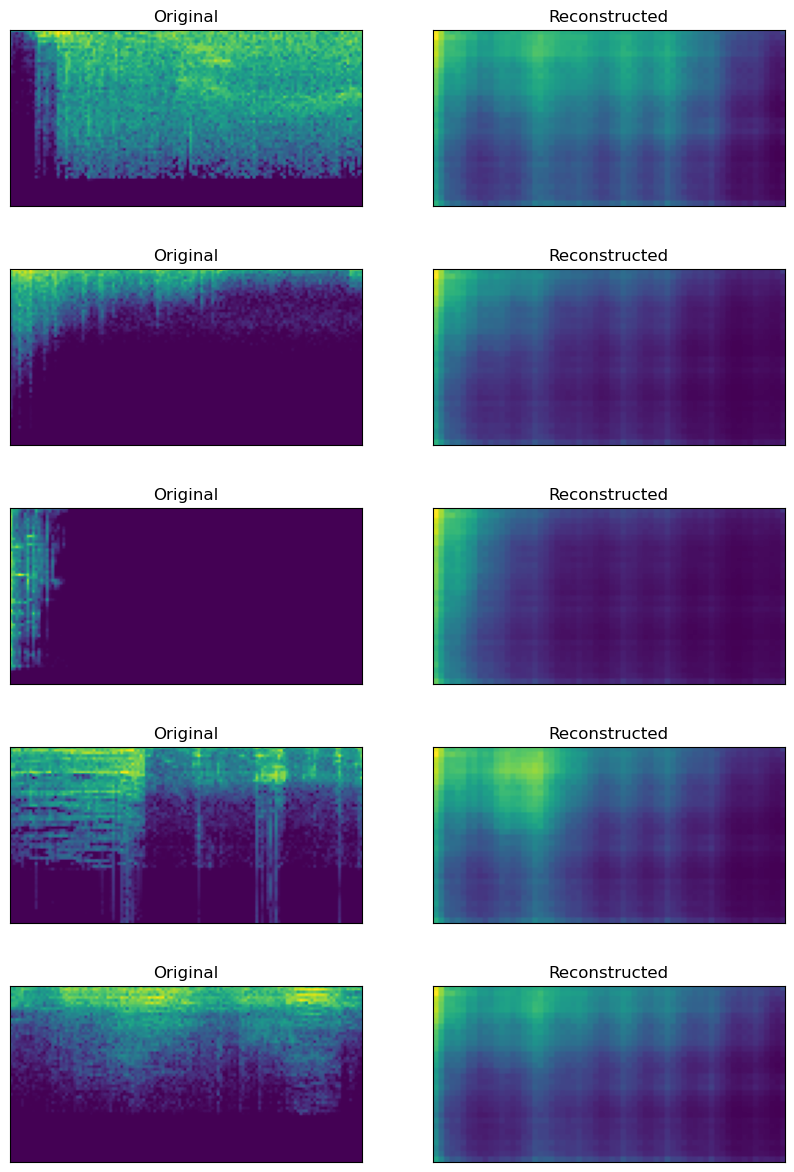

In [20]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Let's try with ESC-10 that has more variability

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


2023-09-11 00:35:42.190787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]
2023-09-11 00:35:42.190996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]


Model: "AE_Conv_prep_flatten_STFT_Augmented"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                211968    
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        392097    
                                                                 
Total params: 604,065
Trainable params: 604,065
Non-trainable params: 0
_________________________________________________________________


2023-09-11 00:35:44.538417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float
	 [[{{node Placeholder/_20}}]]
2023-09-11 00:35:44.538731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float
	 [[{{node Placeholder/_20}}]]


1/1 [==============================] - 0s 14ms/step


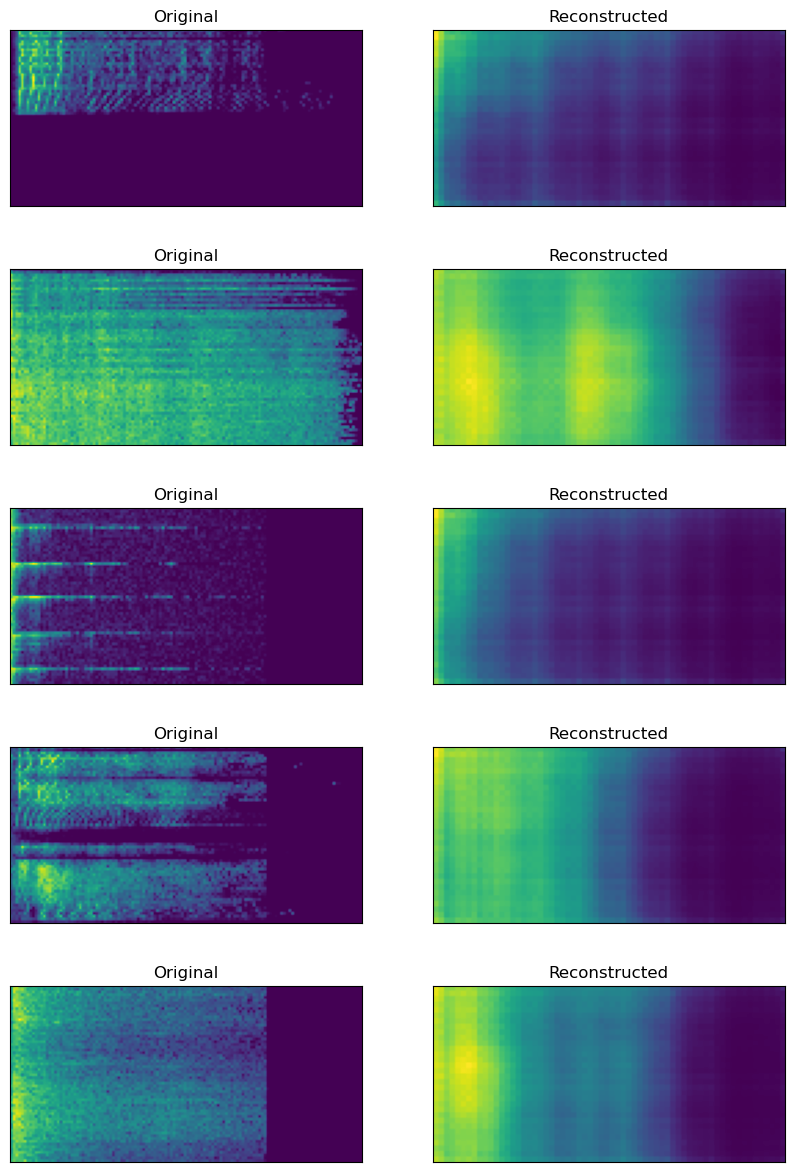

In [15]:
train, val, test, label_names = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)